In [1]:
config='EU36'
case='MPC001'
freq='1d'

year='2012'


In [2]:
# Parameters
config = "EU36"
case = "MPC001"


In [3]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:38034 Dashboard: http://127.0.0.1:40757/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


In [4]:
## path for mdules

import sys
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/xscale")
import xscale

sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/diags-CMEMS-on-occigen/Vorticity_Variance/")
import GriddedData

## imports

import numpy as np
import numpy.ma as ma
import xarray as xr
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm
seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

import glob
import os 

%matplotlib inline

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
if case == 'MPC001':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/'+config+'/'+config+'-I/coordinates_'+config+'.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/'+config+'/'+config+'-I/'+config+'.L75_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'
if case == 'MPC002':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_1/coordinates_EU36.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_1/EU36.L150_1_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_1/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_1/GS36.L150_1_mesh_mask.nc'
if case == 'MPC003':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_2/coordinates_EU36.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_2/EU36.L150_2_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_2/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_2/GS36.L150_2_mesh_mask.nc'
 

In [6]:
## Dataset

dirs="/scratch/cnt0024/hmg2840/colombo/GS36/GS36-MPC001-S/1d/2010/"
dirin="/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I-Aur/"


In [7]:
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']


In [8]:
def filt(w):
    win_box2D = w.window
    win_box2D.set(window='hanning', cutoff=12, dim=['x', 'y'], n=[18, 18])
    bw = win_box2D.boundary_weights(drop_dims=[])
    w_LS = win_box2D.convolve(weights=bw)
    w_SS=w-w_LS
    return w_SS


In [9]:
def plot_fine_scale_variance(var,loncrs,latcrs,lon,lat,hpvarm,month,m,config,case):
    ''' map of the averaged fine scale variance
    '''
    if config == 'EU36':
        fig, ax = plt.subplots(1,1,figsize=(10,15))
    if config == 'GS36':
        fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.autoscale(tight=True)
    cont=np.isnan(hpvarm)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 25, 'color': 'gray'}
    gl.ylabel_style = {'size': 25, 'color': 'gray'}
    
    ax.tick_params('both',labelsize=25)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=seq_cmap,vmin=0,vmax=0.1,alpha=1)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales surface vorticity variance in '+month+' for '+config+'-'+case,fontsize=15)
    plt.savefig('Plots/'+config+'-'+case+'_y'+year+'m'+m+'_fine_scale_variance_vorticity.png')
  

In [10]:
def plot_vorticity_variance(month):
    date_list=[]
    if month == '03':
        dayf=31
    if month == '09':
        dayf=30
    for day in np.arange(1,dayf+1):
        if day < 10:
            date='y'+str(year)+'m'+str(month)+'d0'+str(day)
        else:
            date='y'+str(year)+'m'+str(month)+'d'+str(day)
        date_list.append(date)
    datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
    for date in date_list:
        fileU=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridU.nc'
        fileV=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridV.nc'
        filecurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_socurloverf.nc'
        if not os.path.exists(filecurl):
            print('Computing '+str(filecurl))
            !ln -sf $maskfile mesh_hgr.nc
            !ln -sf $maskfile mesh_zgr.nc
            !cdfcurl -u $fileU vozocrtx -v $fileV vomecrty -l 1 -surf -overf -o $filecurl
            !rm mesh*
    filescurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(month)+'d??.'+str(freq)+'_socurloverf.nc'
    dscurl=xr.open_mfdataset(filescurl,chunks={'time_counter':1,'y':700,'x':1000})
    curl=dscurl.socurloverf
    curl_SS=filt(curl)
    curl_LS=curl-curl_SS
    hpcurl=curl_SS
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=36)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    if month == '03':
        plot_fine_scale_variance(hpcurl2mcm,loncrsm, latcrsm,navlon,navlat,hpcurl2m,'March',month,config,case)
    if month == '09':
        plot_fine_scale_variance(hpcurl2mcm,loncrsm, latcrsm,navlon,navlat,hpcurl2m,'September',month,config,case)
        

Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d01.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d01.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d02.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d02.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d03.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d03.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d04.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d04.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d05.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d05.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d06.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d06.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d07.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d07.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d08.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d08.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d09.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d09.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d10.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d10.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d11.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d11.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d12.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d12.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d13.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d13.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d14.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d14.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d15.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d15.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d16.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d16.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d17.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d17.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d18.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d18.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d19.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d19.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d20.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d20.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d21.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d21.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d22.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d22.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d23.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d23.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d24.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d24.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d25.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d25.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d26.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d26.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d27.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d27.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d28.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d28.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d29.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d29.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d30.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d30.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m03d31.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 3d31.1d_gridU.nc vozocrtx            1           1         732        1718
           1


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d01.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d01.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d02.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d02.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d03.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d03.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d04.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d04.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d05.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d05.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d06.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d06.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d07.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d07.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d08.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d08.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d09.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d09.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d10.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d10.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d11.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d11.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d12.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d12.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d13.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d13.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d14.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d14.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d15.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d15.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d16.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d16.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d17.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d17.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d18.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d18.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d19.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d19.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d20.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d20.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d21.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d21.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d22.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d22.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d23.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d23.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d24.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d24.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d25.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d25.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d26.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d26.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d27.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d27.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d28.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d28.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d29.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d29.1d_gridU.nc vozocrtx            1           1         732        1718
           1


Computing /scratch/cnt0024/hmg2840/albert7a/tmp/EU36-MPC001_y2012m09d30.1d_socurloverf.nc


 npiglo =          732
 npjglo =         1718
 npk    =           75
 npt    =            1
 nlev   =            1
 NLEV           1


 /scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2012/EU36-MPC001_y2012m0
 9d30.1d_gridU.nc vozocrtx            1           1         732        1718
           1


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


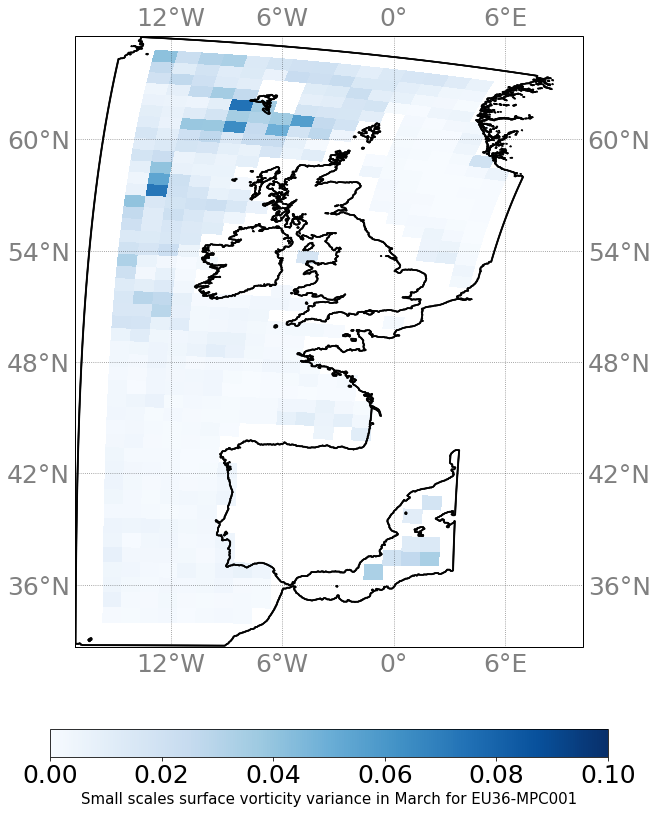

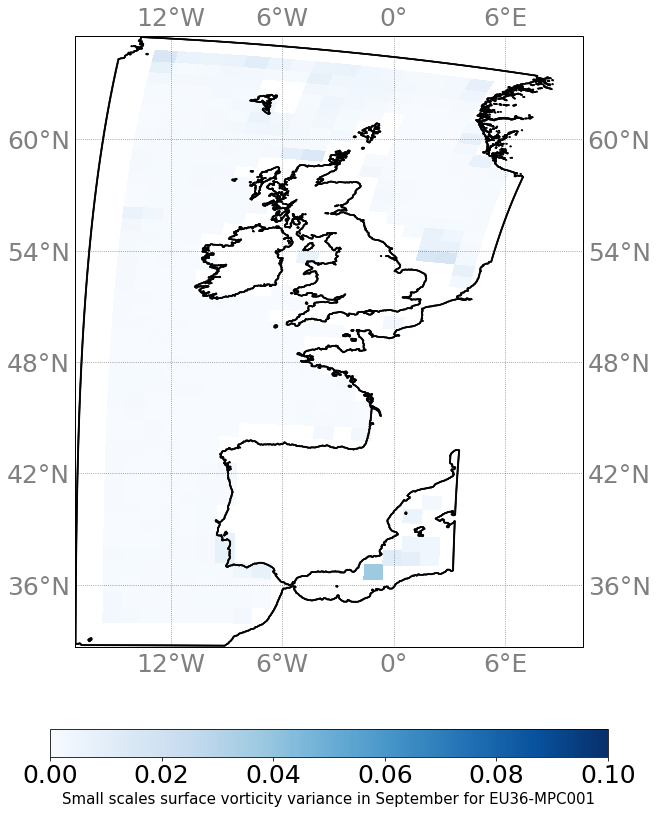

In [11]:
month_list=['03','09']

for month in month_list:
    if not os.path.exists('Plots/'+config+'-'+case+'_y'+year+'m'+month+'_fine_scale_variance_vorticity.png'):
        plot_vorticity_variance(month)